In [1]:
#
# -*- coding: utf-8 -*-
#
# Python-Based Truss Solver
# =============================================================
#
#    Author: Robert Grandin
#
#    Date:   Fall 2007      (Creation of original Fortran solution in AerE 361)
#            October 2011   (Python implementation)
#            November 2014  (Clean-up and graphical/VTK output)
#
#
# PURPOSE:
#    This code solves a truss for the internal load, strain, and stress of each member.
#    Being a truss, all members are assumed to be two-force members and no bending
#    moments are considered.  Both 2-dimensional and 3-dimensional trusses can be
#    solved with this code.
#
#
# INSTRUCTIONS & NOTES:
#    - Dictionaries are used to define the entity properties.  Names for the properties
#      should be self-explanatory.  Some notes:
#       - '_flag' entries identify either displacement ('d') or force ('f') boundary
#         conditions (BCs).  Applied forces require force BCs to be specified.
#         Pin/roller locations require displacement BCs.  Free-to-move nodes will
#         typically have 0-force BCs.
#       - '_bcval' entries specify the BC value for the corresponding flag.
#    - If solving a 2-dimensional problem, constrain node motion in the 3rd
#      dimension to be 0.  Allowing nodal motion in the 3rd dimension (by setting
#      the constraint to 0-force) will produce a matrix with  non-empty null-space.
#      Displacements in the third dimension will reside in this null-space.
#    - Input data can be saved in a python data file.  Create a module for your
#      problem and define a function which returns 'nodes, members'.
#    - Examples shown below for 2D, 3D, and file-based input.  See data file
#      'em514_problem08.py' for an example of how to write an input file.
#
#
# HOMEWORK DISCLAIMER:
#   This tool is intended to be a learning aid.  Feel free to use it to check your
#   work, but do not use it in place of learning how to find the solution yourself.
#
#   When using this tool for statics problems, the member loads calculated by this
#   tool will not match the correct answer for the statics problem.  This is due
#   to the fact that this tool considers displacements whereas displacements are
#   not considered in a statics problem (but displacements are considered in
#   mechanics problems).  Even though the numerical results will not match when
#   checking statics results, the discrepancy should be small enough to enable
#   you to determine if your statics result is correct.
#
#

In [3]:
# Define a 2D demonstration
def  DefineInputs_2D_Demo():
    area = 200.0e-6    
    nodes =     [{'x': 0.0e0, 'y': 0.0e0,  'z': 0.0e0, 'xflag': 'd', 'xbcval': 0.0, 'yflag': 'd', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0}]
    nodes.append({'x': 3.0e0, 'y': 0.0e0,  'z': 0.0e0, 'xflag': 'f', 'xbcval': 0.0, 'yflag': 'f', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0})
    nodes.append({'x': 6.0e0, 'y': 0.0e0,  'z': 0.0e0, 'xflag': 'f', 'xbcval': 0.0, 'yflag': 'f', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0}) 
    nodes.append({'x': 3.0e0, 'y': -4.0e0, 'z': 0.0e0, 'xflag': 'f', 'xbcval': 0.0, 'yflag': 'f', 'ybcval': -9.0e3,   'zflag': 'd', 'zbcval': 0.0e0})
    nodes.append({'x': 6.0e0, 'y': -4.0e0, 'z': 0.0e0, 'xflag': 'f', 'xbcval': 0.0, 'yflag': 'f', 'ybcval': -15.0e3,   'zflag': 'd', 'zbcval': 0.0e0})
    nodes.append({'x': 9.0e0, 'y': -4.0e0, 'z': 0.0e0, 'xflag': 'f', 'xbcval': 0.0, 'yflag': 'd', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0})
    
    members =     [{'start': 0, 'end': 1, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6}]
    members.append({'start': 1, 'end': 2, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 0, 'end': 3, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 1, 'end': 3, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 2, 'end': 3, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 3, 'end': 4, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 2, 'end': 4, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 2, 'end': 5, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 4, 'end': 5, 'E': 200.0e9, 'A': area, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    
    return nodes, members

In [9]:
# Define a 3D demonstration
def  DefineInputs_3D_Demo():
    area = 200.0e-6    
    nodes =     [{'x': 0.0e0,  'y': 0.0e0,  'z': 0.0e0, 'xflag': 'd', 'xbcval': 0.0, 'yflag': 'd', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0}]
    nodes.append({'x': 20.0e0, 'y': 0.0e0,  'z': 0.0e0, 'xflag': 'f', 'xbcval': 0.0, 'yflag': 'f', 'ybcval': 0.0e0,   'zflag': 'f', 'zbcval': 1000.0e0})
    nodes.append({'x': 0.0e0, 'y': 25.0e0,  'z': 0.0e0, 'xflag': 'd', 'xbcval': 0.0, 'yflag': 'd', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0})
    nodes.append({'x': 0.0e0, 'y': 0.0e0,  'z': 10.0e0, 'xflag': 'd', 'xbcval': 0.0, 'yflag': 'd', 'ybcval': 0.0e0,   'zflag': 'd', 'zbcval': 0.0e0})
    
    members =     [{'start': 0, 'end': 1, 'E': 30.0e6, 'A': 1.0e0, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6}]
    members.append({'start': 1, 'end': 2, 'E': 30.0e6, 'A': 1.0e0, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    members.append({'start': 3, 'end': 1, 'E': 30.0e6, 'A': 1.0e0, 'sigma_yield': 36.0e6, 'sigma_ult': 66.0e6})
    
    return nodes, members

In [10]:
# Define 'nodes' and 'members' using an above-defined function.
nodes, members = DefineInputs_3D_Demo()

# Set scale factor to make display more-easily understood.
displayScaleFactor = 100.0


 
 
        INPUT INFORMATION
 
 
Pin Input Information
--------------------------------------
Node   0
  Position: (            0,            0,            0 )
  BC Type:  (            d,            d,            d )
  BC Value: (            0,            0,            0 )
 
Node   1
  Position: (           20,            0,            0 )
  BC Type:  (            f,            f,            f )
  BC Value: (            0,            0,        1e+03 )
 
Node   2
  Position: (            0,           25,            0 )
  BC Type:  (            d,            d,            d )
  BC Value: (            0,            0,            0 )
 
Node   3
  Position: (            0,            0,           10 )
  BC Type:  (            d,            d,            d )
  BC Value: (            0,            0,            0 )
 
 
 
 
Member Input Information
--------------------------------------
Member   0
  Start, end nodes: (   0,   1 )
  Young's Modulus:             3e+07
  Cross-sectional Area:   

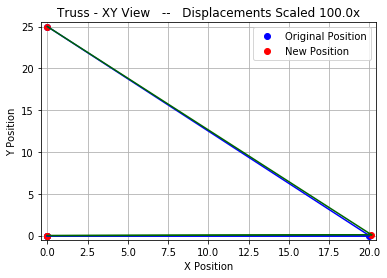

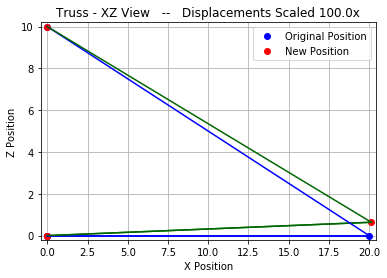

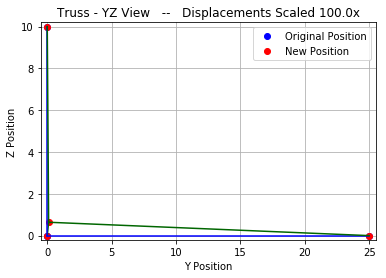

In [11]:
# =============================================================================================
#
#
#
#             NO EDITS REQUIRED BELOW HERE
#
#
#
# =============================================================================================





# ========================
#
#    IMPORT PYTHON MODULES REQUIRED FOR SOLUTION
#

import numpy    # General linear algebra capability
import scipy    # Advanced routines for evaluating solution quality
import matplotlib.pyplot as plt     # 2D plotting






# ========================
#
#    ECHO INPUT VALUES TO SCREEN
#

# Calculate Member Properties
nnodes = len(nodes)
nmem = len(members)

# Write Input Information
print(' ')
print('==============================================')
print(' ')
print('        INPUT INFORMATION')
print(' ')
print('==============================================')
print(' ')
print('Pin Input Information')
print('--------------------------------------')
for i in range(nnodes):
    print('Node % 3d' % (i))
    print('  Position: ( % 12.3g, % 12.3g, % 12.3g )' % (nodes[i]['x'], nodes[i]['y'], nodes[i]['z']))
    print('  BC Type:  ( %*.*s, %*.*s, %*.*s )' % (12,12,nodes[i]['xflag'], 12,12,nodes[i]['yflag'], 12,12,nodes[i]['zflag']))
    print('  BC Value: ( % 12.3g, % 12.3g, % 12.3g )' % (nodes[i]['xbcval'], nodes[i]['ybcval'], nodes[i]['zbcval']))
    print(' ')

print(' ')
print(' ')
print(' ')
print('Member Input Information')
print('--------------------------------------')
for i in range(nmem):
    print('Member % 3d' % (i))
    print('  Start, end nodes: ( % 3d, % 3d )' % (members[i]['start'], members[i]['end']))
    print('  Young\'s Modulus:      % 12.3g' % (members[i]['E']))
    print('  Cross-sectional Area: % 12.3g' % (members[i]['A']))
    print('  Yield Strength:       % 12.3g' % (members[i]['sigma_yield']))
    print('  Ultimate Strength:    % 12.3g' % (members[i]['sigma_ult']))
    print(' ')

print(' ')
print(' ')
print(' ')








# ========================
#
#    SETUP MATRIX EQUATION AND SOLVE
#

# Calculate member properties
for i in range(nmem):
    dx = nodes[members[i]['end']]['x'] - nodes[members[i]['start']]['x']
    dy = nodes[members[i]['end']]['y'] - nodes[members[i]['start']]['y']
    dz = nodes[members[i]['end']]['z'] - nodes[members[i]['start']]['z']
    members[i]['L'] = numpy.sqrt(dx*dx + dy*dy + dz*dz)
    members[i]['costheta_x'] = dx/members[i]['L']
    members[i]['costheta_y'] = dy/members[i]['L']
    members[i]['costheta_z'] = dz/members[i]['L']


# Build stiffness matrix
stiffness = numpy.zeros((3*nnodes,3*nnodes), dtype='float64')
G = numpy.zeros((6,6), dtype='float64')
for i in range(nmem):
    tbm2 = 3*members[i]['start'] + 2
    tbm1 = 3*members[i]['start'] + 1
    tb = 3*members[i]['start']
    tem2 = 3*members[i]['end'] + 2
    tem1 = 3*members[i]['end'] + 1
    te = 3*members[i]['end']
    k = members[i]['A']*members[i]['E']/members[i]['L']

    stiffness[tb][tb]   += k*members[i]['costheta_x']*members[i]['costheta_x']
    stiffness[tb][tbm1] += k*members[i]['costheta_x']*members[i]['costheta_y']
    stiffness[tb][tbm2] += k*members[i]['costheta_x']*members[i]['costheta_z']
    stiffness[tb][te]   += -k*members[i]['costheta_x']*members[i]['costheta_x']
    stiffness[tb][tem1] += -k*members[i]['costheta_x']*members[i]['costheta_y']
    stiffness[tb][tem2] += -k*members[i]['costheta_x']*members[i]['costheta_z']

    stiffness[tbm1][tb]   += k*members[i]['costheta_y']*members[i]['costheta_x']
    stiffness[tbm1][tbm1] += k*members[i]['costheta_y']*members[i]['costheta_y']
    stiffness[tbm1][tbm2] += k*members[i]['costheta_y']*members[i]['costheta_z']
    stiffness[tbm1][te]   += -k*members[i]['costheta_y']*members[i]['costheta_x']
    stiffness[tbm1][tem1] += -k*members[i]['costheta_y']*members[i]['costheta_y']
    stiffness[tbm1][tem2] += -k*members[i]['costheta_y']*members[i]['costheta_z']

    stiffness[tbm2][tb]   += k*members[i]['costheta_z']*members[i]['costheta_x']
    stiffness[tbm2][tbm1] += k*members[i]['costheta_z']*members[i]['costheta_y']
    stiffness[tbm2][tbm2] += k*members[i]['costheta_z']*members[i]['costheta_z']
    stiffness[tbm2][te]   += -k*members[i]['costheta_z']*members[i]['costheta_x']
    stiffness[tbm2][tem1] += -k*members[i]['costheta_z']*members[i]['costheta_y']
    stiffness[tbm2][tem2] += -k*members[i]['costheta_z']*members[i]['costheta_z']

    stiffness[te][tb]   += -k*members[i]['costheta_x']*members[i]['costheta_x']
    stiffness[te][tbm1] += -k*members[i]['costheta_x']*members[i]['costheta_y']
    stiffness[te][tbm2] += -k*members[i]['costheta_x']*members[i]['costheta_z']
    stiffness[te][te]   += k*members[i]['costheta_x']*members[i]['costheta_x']
    stiffness[te][tem1] += k*members[i]['costheta_x']*members[i]['costheta_y']
    stiffness[te][tem2] += k*members[i]['costheta_x']*members[i]['costheta_z']

    stiffness[tem1][tb]   += -k*members[i]['costheta_y']*members[i]['costheta_x']
    stiffness[tem1][tbm1] += -k*members[i]['costheta_y']*members[i]['costheta_y']
    stiffness[tem1][tbm2] += -k*members[i]['costheta_y']*members[i]['costheta_z']
    stiffness[tem1][te]   += k*members[i]['costheta_y']*members[i]['costheta_x']
    stiffness[tem1][tem1] += k*members[i]['costheta_y']*members[i]['costheta_y']
    stiffness[tem1][tem2] += k*members[i]['costheta_y']*members[i]['costheta_z']

    stiffness[tem2][tb]   += -k*members[i]['costheta_z']*members[i]['costheta_x']
    stiffness[tem2][tbm1] += -k*members[i]['costheta_z']*members[i]['costheta_y']
    stiffness[tem2][tbm2] += -k*members[i]['costheta_z']*members[i]['costheta_z']
    stiffness[tem2][te]   += k*members[i]['costheta_z']*members[i]['costheta_x']
    stiffness[tem2][tem1] += k*members[i]['costheta_z']*members[i]['costheta_y']
    stiffness[tem2][tem2] += k*members[i]['costheta_z']*members[i]['costheta_z']



# Calculate average of main diagonal for numerical stability
average = 0.0e0
for i in range(3*nnodes):
    average += stiffness[i][i]

average /= float(3*nnodes)


# Create and fill arrays to be used when solving matrix equation
A = numpy.zeros(stiffness.shape, dtype='float64')
b = numpy.zeros((3*nnodes,1), dtype='float64')
for i in range(nnodes):
    icol = 3*i
    if(nodes[i]['xflag'] == 'd'):
        for j in range(3*nnodes):
            b[j] -= stiffness[j][icol]*nodes[i]['xbcval']
        A[icol][icol] = -average

    if(nodes[i]['xflag'] == 'f'):
        b[icol] += nodes[i]['xbcval']
        for j in range(3*nnodes):
            A[j][icol] = stiffness[j][icol]

    icol = 3*i + 1
    if(nodes[i]['yflag'] == 'd'):
        for j in range(3*nnodes):
            b[j] -= stiffness[j][icol]*nodes[i]['ybcval']
        A[icol][icol] = -average

    if(nodes[i]['yflag'] == 'f'):
        b[icol] += nodes[i]['ybcval']
        for j in range(3*nnodes):
            A[j][icol] = stiffness[j][icol]

    icol = 3*i + 2
    if(nodes[i]['zflag'] == 'd'):
        for j in range(3*nnodes):
            b[j] -= stiffness[j][icol]*nodes[i]['zbcval']
        A[icol][icol] = -average

    if(nodes[i]['zflag'] == 'f'):
        b[icol] += nodes[i]['zbcval']
        for j in range(3*nnodes):
            A[j][icol] = stiffness[j][icol]



# Solve the system
x,res,rank,singularvals = numpy.linalg.lstsq(A,b,rcond=None)

# Calculate nodal results
for i in range(nnodes):
    if(nodes[i]['xflag'] == 'f'):
        nodes[i]['xdisp'] = x[3*i+0][0]
        nodes[i]['xforce'] = nodes[i]['xbcval']

    if(nodes[i]['xflag'] == 'd'):
        nodes[i]['xdisp'] = nodes[i]['xbcval']
        nodes[i]['xforce'] = x[3*i+0][0]

    if(nodes[i]['yflag'] == 'f'):
        nodes[i]['ydisp'] = x[3*i+1][0]
        nodes[i]['yforce'] = nodes[i]['ybcval']

    if(nodes[i]['yflag'] == 'd'):
        nodes[i]['ydisp'] = nodes[i]['ybcval']
        nodes[i]['yforce'] = x[3*i+1][0]

    if(nodes[i]['zflag'] == 'f'):
        nodes[i]['zdisp'] = x[3*i+2][0]
        nodes[i]['zforce'] = nodes[i]['zbcval']

    if(nodes[i]['zflag'] == 'd'):
        nodes[i]['zdisp'] = nodes[i]['zbcval']
        nodes[i]['zforce'] = x[3*i+2][0]

    nodes[i]['xnew'] = nodes[i]['x'] + nodes[i]['xdisp']
    nodes[i]['ynew'] = nodes[i]['y'] + nodes[i]['ydisp']
    nodes[i]['znew'] = nodes[i]['z'] + nodes[i]['zdisp']


# Calculate member results
for i in range(nmem):
    dx = nodes[members[i]['end']]['xnew'] - nodes[members[i]['start']]['xnew']
    dy = nodes[members[i]['end']]['ynew'] - nodes[members[i]['start']]['ynew']
    dz = nodes[members[i]['end']]['znew'] - nodes[members[i]['start']]['znew']
    members[i]['Lnew'] = numpy.sqrt(dx*dx + dy*dy + dz*dz)
    members[i]['epsilon'] = (members[i]['Lnew'] - members[i]['L'])/members[i]['L']
    members[i]['stress'] = members[i]['epsilon']*members[i]['E']
    members[i]['load'] = members[i]['stress']*members[i]['A']

# Calculate null space of A (http://stackoverflow.com/questions/2992947/calculating-the-null-space-of-a-matrix)
u, s, vh = numpy.linalg.svd(A)
null_mask = (s <= 1.0e-15)
null_space = scipy.compress(null_mask, vh, axis=0)
nullspace = scipy.transpose(null_space)







# ========================
#
#    OUTPUT RESULTS TO TERMINAL
#

print(' ')
print('==============================================')
print(' ')
print('        RESULTS')
print(' ')
print('==============================================')
print(' ')
print('Pin Displacements (x,y,z)')
print('--------------------------------------')
for i in range(nnodes):
    print('Node  % 3d: % 10.5e   % 10.5e   % 10.5e' % (i,nodes[i]['xdisp'],nodes[i]['ydisp'],nodes[i]['zdisp']))

print(' ')
print(' ')
print('Member Results')
print('--------------------------------------')
for i in range(nmem):
    print('Member % 3d:' % (i))
    print('  Internal Load: % 10.5e' % (members[i]['load']))
    print('  Axial Strain:  % 10.5e' % (members[i]['epsilon']))
    print('  Axial Stress:  % 10.5e' % (members[i]['stress']))

    if(members[i]['stress'] > members[i]['sigma_yield']):
        if(members[i]['stress'] < members[i]['sigma_ult']):
            print('          --> YIELD STRESS SURPASSED')
        if(members[i]['stress'] > members[i]['sigma_ult']):
            print('          --> ULTIMATE STRESS SURPASSED')

    print(' ')

print(' ')
print(' ')
print(' ')
print('==============================================')
print(' ')
print('        SOLUTION QUALITY INDICATORS')
print(' ')
print('==============================================')
print(' ')
print('Rank of A matrix: %d' % (rank))
print(' ')
print('Size of A: %d' % (3*nnodes))
print(' ')
print('Condition Number: % 10.3e (smaller is better)' % (singularvals.max()/singularvals.min()))
print('  General rule: If condition number is O(10^n), discard last n digits')
print('                from the results.')
print(' ')
print('Singular values: ')
for i in range(len(singularvals)):
    print('  % 12.10g' % (singularvals[i]))
print(' ')
print('Nullspace of A:')
print(nullspace)






# ========================
#
#    GENERATE PLOTS
#

xOriginal = numpy.zeros((nnodes))
yOriginal = numpy.zeros((nnodes))
zOriginal = numpy.zeros((nnodes))

xNew = numpy.zeros((nnodes))
yNew = numpy.zeros((nnodes))
zNew = numpy.zeros((nnodes))

for i in range(nnodes):
    xOriginal[i] = nodes[i]['x']
    xNew[i] = xOriginal[i] + nodes[i]['xdisp']*displayScaleFactor

    yOriginal[i] = nodes[i]['y']
    yNew[i] = yOriginal[i] + nodes[i]['ydisp']*displayScaleFactor

    zOriginal[i] = nodes[i]['z']
    zNew[i] = zOriginal[i] + nodes[i]['zdisp']*displayScaleFactor


xmin1 = numpy.min(xOriginal)
xmin2 = numpy.min(xNew)
xmin = min(xmin1,xmin2)

ymin1 = numpy.min(yOriginal)
ymin2 = numpy.min(yNew)
ymin = min(ymin1,ymin2)

zmin1 = numpy.min(zOriginal)
zmin2 = numpy.min(zNew)
zmin = min(zmin1,zmin2)

xmax1 = numpy.max(xOriginal)
xmax2 = numpy.max(xNew)
xmax = min(xmax1,xmax2)

ymax1 = numpy.max(yOriginal)
ymax2 = numpy.max(yNew)
ymax = min(ymax1,ymax2)

zmax1 = numpy.max(zOriginal)
zmax2 = numpy.max(zNew)
zmax = min(zmax1,zmax2)

xRange = xmax - xmin
yRange = ymax - ymin
zRange = zmax - zmin

factor = 0.02

# Generate XY view
plt.figure()
plt.plot(xOriginal, yOriginal, 'ob', label='Original Position')
#plt.hold(True)
plt.plot(xNew, yNew, 'or', label='New Position')
for i in range(nmem):
    xx = [xOriginal[members[i]['start']], xOriginal[members[i]['end']]]
    yy = [yOriginal[members[i]['start']], yOriginal[members[i]['end']]]
    plt.plot(xx, yy, '-b')
    xx2 = [xNew[members[i]['start']], xNew[members[i]['end']]]
    yy2 = [yNew[members[i]['start']], yNew[members[i]['end']]]
    if(members[i]['stress'] > members[i]['sigma_yield']):
        if(members[i]['stress'] < members[i]['sigma_ult']):
            plt.plot(xx2, yy2, color="#ffa500")
        if(members[i]['stress'] > members[i]['sigma_ult']):
            plt.plot(xx2, yy2, color="#ff2500")
    else:
        plt.plot(xx2, yy2, color="#006600")

plt.xlim([xmin - xRange*factor, xmax + xRange*factor])
plt.ylim([ymin - yRange*factor, ymax + yRange*factor])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Truss - XY View   --   Displacements Scaled ' + str(displayScaleFactor) + 'x')
plt.grid(True)
plt.legend()
plt.savefig('Truss_XY_View.png')




# If displacement in the Z-direction exists, plot XZ and YZ views.  Note that
# the zRange cannot be compared to precisely '0' due to floating-point errors,
# so it is compared to a very small value instead.  Also note that 'x' and 'y'
# refer to the 2D plot and therefore do not necessarily correspond directly
# to the 'x' and 'y' coordinates of the nodes.
if(zRange > 1.0e-5):
    plt.figure()
    plt.plot(xOriginal, zOriginal, 'ob', label='Original Position')
    #plt.hold(True)
    plt.plot(xNew, zNew, 'or', label='New Position')
    for i in range(nmem):
        xx = [xOriginal[members[i]['start']], xOriginal[members[i]['end']]]
        yy = [zOriginal[members[i]['start']], zOriginal[members[i]['end']]]
        plt.plot(xx, yy, '-b')
        xx2 = [xNew[members[i]['start']], xNew[members[i]['end']]]
        yy2 = [zNew[members[i]['start']], zNew[members[i]['end']]]
        if(members[i]['stress'] > members[i]['sigma_yield']):
            if(members[i]['stress'] < members[i]['sigma_ult']):
                plt.plot(xx2, yy2, color="#ffa500")
            if(members[i]['stress'] > members[i]['sigma_ult']):
                plt.plot(xx2, yy2, color="#ff2500")
        else:
            plt.plot(xx2, yy2, color="#006600")
    plt.xlim([xmin - xRange*factor, xmax + xRange*factor])
    plt.ylim([zmin - zRange*factor, zmax + zRange*factor])
    plt.xlabel('X Position')
    plt.ylabel('Z Position')
    plt.title('Truss - XZ View   --   Displacements Scaled ' + str(displayScaleFactor) + 'x')
    plt.grid(True)
    plt.legend()
    plt.savefig('Truss_XZ_View.png')

    plt.figure()
    plt.plot(yOriginal, zOriginal, 'ob', label='Original Position')
    #plt.hold(True)
    plt.plot(yNew, zNew, 'or', label='New Position')
    for i in range(nmem):
        xx = [yOriginal[members[i]['start']], yOriginal[members[i]['end']]]
        yy = [zOriginal[members[i]['start']], zOriginal[members[i]['end']]]
        plt.plot(xx, yy, '-b')
        xx2 = [yNew[members[i]['start']], yNew[members[i]['end']]]
        yy2 = [zNew[members[i]['start']], zNew[members[i]['end']]]
        if(members[i]['stress'] > members[i]['sigma_yield']):
            if(members[i]['stress'] < members[i]['sigma_ult']):
                plt.plot(xx2, yy2, color="#ffa500")
            if(members[i]['stress'] > members[i]['sigma_ult']):
                plt.plot(xx2, yy2, color="#ff2500")
        else:
            plt.plot(xx2, yy2, color="#006600")
    plt.xlim([ymin - yRange*factor, ymax + yRange*factor])
    plt.ylim([zmin - zRange*factor, zmax + zRange*factor])
    plt.xlabel('Y Position')
    plt.ylabel('Z Position')
    plt.title('Truss - YZ View   --   Displacements Scaled ' + str(displayScaleFactor) + 'x')
    plt.grid(True)
    plt.legend()
    plt.savefig('Truss_YZ_View.png')






# Write results to VTK files to enable more-flexible visualization via ParaView
# (or any other VTK-supporting viewer)

f = open('TrussOriginal.vtk', 'w')

f.write("# vtk DataFile Version 2.0 \n")
f.write("Truss - Original Configuration \n")
f.write("ASCII \n")
f.write("DATASET UNSTRUCTURED_GRID \n")

f.write("Points " + str(nnodes) + " float \n")
for i in range(nnodes):
    f.write(str(nodes[i]['x']) + " " + str(nodes[i]['y']) + " " + str(nodes[i]['z']) + " \n")

f.write("Cells " + str(nmem) + " " + str(nmem*3) + " \n")
for i in range(nmem):
    f.write("2 " + str(members[i]['start']) + " " + str(members[i]['end']) + " \n")

f.write("Cell_Types " + str(nmem) + " \n")
for i in range(nmem):
    f.write("3 \n")     # All "cells" are of type VTK_LINE

f.close()




f = open('TrussNew.vtk', 'w')

f.write("# vtk DataFile Version 2.0 \n")
f.write("Truss - Deformed Configuration - Deformation scaled by  " + str(displayScaleFactor) + "x \n")
f.write("ASCII \n")
f.write("DATASET UNSTRUCTURED_GRID \n")

f.write("Points " + str(nnodes) + " float \n")
for i in range(nnodes):
    f.write(str(xNew[i]) + " " + str(yNew[i]) + " " + str(zNew[i]) + " \n")

f.write("Cells " + str(nmem) + " " + str(nmem*3) + " \n")
for i in range(nmem):
    f.write("2 " + str(members[i]['start']) + " " + str(members[i]['end']) + " \n")

f.write("Cell_Types " + str(nmem) + " \n")
for i in range(nmem):
    f.write("3 \n")     # All "cells" are of type VTK_LINE

f.close()
